# Tutorial 3: Sweeping through models
This is a tutorial for finding optimal damping parameters by sweeping through a range of possible models created by the Geomagnetic Field Inversions code written by Frenk Out, Maximilian Schanner, Liz van Grinsven, Monika Korte, and Lennart de Groot.

### 0. Loading libraries and set-up
This tutorial requires, besides geomagnetic_field_inversions, numpy, pandas, pathlib, and matplotlib.

In [1]:
import numpy as np
# Necessary for loading excel/csv files and creating DataFrames
import pandas as pd
# Necessary for correct path handling
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl

# Our code
from geomagnetic_field_inversions import InputData, FieldInversion, tools

In [2]:
# Quickly load data
path = Path().absolute()
dataset = pd.read_csv(path / 'example_data.csv', index_col=0)
inputdata = InputData(dataset)

## 1. Sweeping through models to find optimal damping parameters
Normally we do not have the optimal damping parameters yet, which is why we will have to search for them **now**. 

#### *a) set-up*
We will start a new class, add all our data, and specify the requested damping types similar to Tutorial 1.

In [3]:
# set class and add data
sweep_inv = FieldInversion(t_min=-2000, t_max=1990, t_step=10, maxdegree=10)
sweep_inv.prepare_inversion(inputdata, spat_type='ohmic_heating', temp_type='min_acc')

#### *b) sweep_damping*
This method enables us to sweep through the parameters, it requires the following parameters:
1. x0: starting model, with length equal to the number of Gauss coefficients
  2. spatial_range: the range of spatial damping parameters to be tested
  3. temporal_range: the range of temporal damping parameters to be tested
  4. (optional) max_iter: the maximum number of iterations used (defaults to 10)
  5. (optional) basedir: path where to store the generated files (defaults to location of this script)
  6. (optional) overwrite: whether to overwrite existing files with results for same damping parameter (defaults to True)

We set our range of damping parameters, and have a look at the damping vs residual plot

In [4]:
spatial_range = np.logspace(-15, -11, 5)
temporal_range = np.logspace(-7, -1, 7)
x0 = np.zeros(sweep_inv._nr_coeffs)
x0[0] = -30000

sweep_inv.sweep_damping(x0, spatial_range, temporal_range, basedir= path / 'output')

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [1:06:48<00:00, 801.66s/it]


After performing the calculations, we will plot the results of the damping parameters. The best model would be the model that produces a low residual and a small model size (=norm of the Gauss coefficients).

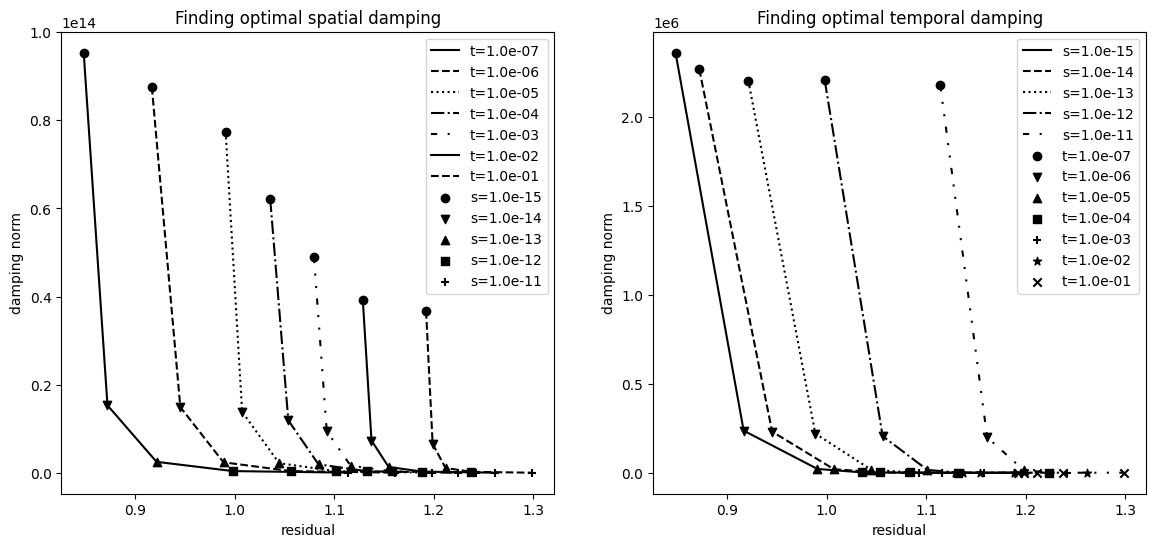

In [5]:
# Now we plot residual vs norm of the model
# first create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title('Finding optimal spatial damping')
axes[1].set_title('Finding optimal temporal damping')
basedir = path / 'output'
# define some plot styles
marker = ['o', 'v', '^', 's', '+', '*', 'x', 'd']
lstyle = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 5, 1, 5, 1, 5))]

# read all files and retrieve damping norm
spatnorm = np.zeros((len(spatial_range), len(temporal_range)))
tempnorm = np.zeros((len(spatial_range), len(temporal_range)))
sumspat = np.zeros((len(spatial_range), len(temporal_range)))
sumtemp = np.zeros((len(spatial_range), len(temporal_range)))
res = np.zeros((len(spatial_range), len(temporal_range)))
for j, temporal_df in enumerate(temporal_range):
    for i, spatial_df in enumerate(spatial_range):
        filename = f'{spatial_df:.2e}s+{temporal_df:.2e}t_damp.npz'
        data = np.load(basedir / filename)
        spatnorm[i, j] = data['sum_spat']
        tempnorm[i, j] = data['sum_temp']
        res[i, j] = pd.read_csv(
            basedir / f'{spatial_df:.2e}s+{temporal_df:.2e}t_residual.csv',
            delimiter=';').to_numpy()[-1, -1]

# start the plotting
tp_ranges = [temporal_range, spatial_range]
ts = ['t', 's']
for p in range(2):
    axes[p].set_xlabel('residual')
    axes[p].set_ylabel('damping norm')
    modelsize = spatnorm
    if p == 1:
        res = res.T
        modelsize = tempnorm.T
    for i in range(len(tp_ranges[p])):
        axes[p].plot(res[:, i], modelsize[:, i], color='black',
                     linestyle=lstyle[i % len(lstyle)],
                     label=f'{ts[p]}={tp_ranges[p][i]:.1e}')
    for i in range(len(tp_ranges[p])):
        for j in range(len(tp_ranges[~p])):
            if i == 0:
                axes[p].scatter(res[j, i], modelsize[j, i], color='black',
                                marker=marker[j % len(marker)],
                                label=f'{ts[~p]}={tp_ranges[~p][j]:.1e}')
            else:
                axes[p].scatter(res[j, i], modelsize[j, i], color='black',
                                marker=marker[j % len(marker)])

axes[0].legend()
axes[1].legend()
plt.show()

#### conclusion
A spatial damping factor around 1e-13 seems to be best; it results in both a low residual and small Gauss coefficients, so our initial assumption of 1e-13 (see Tutorial 1) was good enough. For the temporal damping factor, a damping factor between 1e-6 and 1e-5 seems optimal. We previously used 1e-1, so we could make our main model (see Tutorial 1) even better! Have a look at the powerspectra below, and judge it yourself.

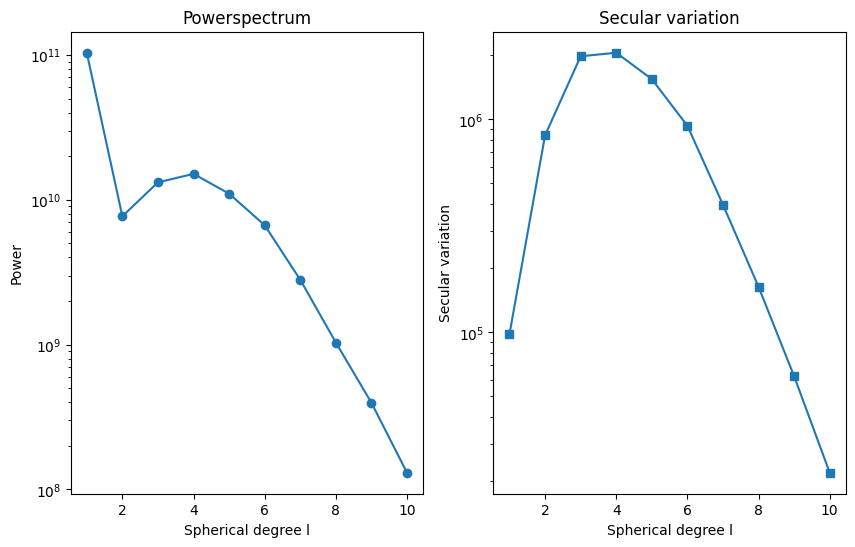

In [6]:
sweep_inv.run_inversion(x0, spat_damp=1e-13, temp_damp=1e-5)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].set_title('Powerspectrum')
axes[0].set_xlabel('Spherical degree l')
axes[0].set_ylabel('Power')
axes[1].set_title('Secular variation')
axes[1].set_xlabel('Spherical degree l')
axes[1].set_ylabel('Secular variation')
sum_coeff_pow, sum_coeff_sv = tools.calc_spectra(
    sweep_inv.coeffs_per_iteration[-1], sweep_inv.maxdegree, sweep_inv.t_step, cmb=True)
axes[0].plot(np.arange(1, sweep_inv.maxdegree + 1), sum_coeff_pow,
             marker='o', label='power')
axes[1].plot(np.arange(1, sweep_inv.maxdegree + 1), sum_coeff_sv,
             marker='s', label='variance')
axes[0].set_yscale('log')
axes[1].set_yscale('log')

plt.show()